# Feature Extration

In [2]:
import librosa
import numpy as np
import torch

def extract_features_cnn(file_path, sr=44100, n_mfcc=20):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=sr)

    # Extract features
    rms = librosa.feature.rms(y=y).flatten()
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr).flatten()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).flatten()
    zcr = librosa.feature.zero_crossing_rate(y).flatten()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Stack features into a 2D "image"
    features = np.vstack([rms, spec_cent, spec_bw, rolloff, zcr, mfcc])
    return features  # Shape: (25, num_frames)

# Data Preparation

In [4]:
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import pickle

# Define the custom Dataset class
class InstrumentDataset(Dataset):
    def __init__(self, dataset_path, instruments, label_encoder, transform=None):
        self.dataset_path = dataset_path
        self.instruments = instruments
        self.label_encoder = label_encoder
        self.transform = transform

        # Collect file paths and labels
        self.file_paths = []
        self.labels = []

        for instrument in instruments:
            folder_path = os.path.join(dataset_path, instrument)
            for filename in os.listdir(folder_path):
                self.file_paths.append(os.path.join(folder_path, filename))
                self.labels.append(instrument)

        # Encode labels
        self.labels = label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Extract features
        features = extract_features_cnn(file_path)
        features = torch.tensor(features, dtype=torch.float32)

        # Apply transformations if provided
        if self.transform:
            features = self.transform(features)

        # Add a channel dimension for CNN
        features = features.unsqueeze(0)  # Shape: (1, 25, num_frames)

        return features, label


# Dataset path and instruments
dataset_path = "./../IRMAS/IRMAS-TrainingData"
instruments = 'flu pia tru org gac voi cel cla gel sax vio'.split()

# Label encoder
label_encoder = LabelEncoder()

# Create dataset and dataloader
total_dataset = InstrumentDataset(dataset_path, instruments, label_encoder)

# Split dataset into training and test sets
dataset_size = len(total_dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Subset datasets
train_subset = torch.utils.data.Subset(total_dataset, train_indices)
test_subset = torch.utils.data.Subset(total_dataset, test_indices)


# Save the label encoder for later
with open("label_encoder_cnn.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

# CNN Model


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 25, 258)  # (Batch size, Channels, Height, Width)
        with torch.no_grad():
            dummy_output = self.pool(self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input))))))
        flattened_size = dummy_output.numel()  # Use .numel() to get the total number of elements
        
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## CNN Training


In [15]:
import torch.optim as optim
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = len(instruments)  # Number of instrument classes
model = AudioCNN(num_classes=num_classes).to(device)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

train_accuracies = []
epoch_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    epoch_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Using device: cuda
AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=24576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)


100%|██████████| 84/84 [08:05<00:00,  5.77s/it]


Epoch 1/100, Loss: 50.5987, Accuracy: 0.1283


100%|██████████| 84/84 [08:07<00:00,  5.80s/it]


Epoch 2/100, Loss: 2.3354, Accuracy: 0.1628


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 3/100, Loss: 2.2698, Accuracy: 0.1957


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 4/100, Loss: 2.2160, Accuracy: 0.1928


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 5/100, Loss: 2.1772, Accuracy: 0.2138


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 6/100, Loss: 2.1596, Accuracy: 0.2304


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 7/100, Loss: 2.0972, Accuracy: 0.2532


100%|██████████| 84/84 [07:58<00:00,  5.70s/it]


Epoch 8/100, Loss: 2.0233, Accuracy: 0.2804


100%|██████████| 84/84 [07:59<00:00,  5.71s/it]


Epoch 9/100, Loss: 1.9456, Accuracy: 0.3192


100%|██████████| 84/84 [07:58<00:00,  5.69s/it]


Epoch 10/100, Loss: 1.8609, Accuracy: 0.3503


100%|██████████| 84/84 [07:56<00:00,  5.68s/it]


Epoch 11/100, Loss: 1.7328, Accuracy: 0.3894


100%|██████████| 84/84 [07:58<00:00,  5.70s/it]


Epoch 12/100, Loss: 1.6293, Accuracy: 0.4234


100%|██████████| 84/84 [07:56<00:00,  5.67s/it]


Epoch 13/100, Loss: 1.4948, Accuracy: 0.4778


100%|██████████| 84/84 [07:57<00:00,  5.69s/it]


Epoch 14/100, Loss: 1.3732, Accuracy: 0.5144


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 15/100, Loss: 1.3065, Accuracy: 0.5457


100%|██████████| 84/84 [08:09<00:00,  5.83s/it]


Epoch 16/100, Loss: 1.1686, Accuracy: 0.5938


100%|██████████| 84/84 [08:08<00:00,  5.82s/it]


Epoch 17/100, Loss: 1.0881, Accuracy: 0.6264


100%|██████████| 84/84 [08:09<00:00,  5.83s/it]


Epoch 18/100, Loss: 0.9882, Accuracy: 0.6545


100%|██████████| 84/84 [08:07<00:00,  5.80s/it]


Epoch 19/100, Loss: 0.8949, Accuracy: 0.6902


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 20/100, Loss: 0.8533, Accuracy: 0.7079


100%|██████████| 84/84 [08:03<00:00,  5.76s/it]


Epoch 21/100, Loss: 0.7730, Accuracy: 0.7314


100%|██████████| 84/84 [08:05<00:00,  5.77s/it]


Epoch 22/100, Loss: 0.6942, Accuracy: 0.7582


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 23/100, Loss: 0.6629, Accuracy: 0.7685


100%|██████████| 84/84 [08:05<00:00,  5.77s/it]


Epoch 24/100, Loss: 0.5882, Accuracy: 0.7912


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 25/100, Loss: 0.5544, Accuracy: 0.8102


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 26/100, Loss: 0.5215, Accuracy: 0.8136


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 27/100, Loss: 0.4920, Accuracy: 0.8290


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 28/100, Loss: 0.4589, Accuracy: 0.8371


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 29/100, Loss: 0.4301, Accuracy: 0.8510


100%|██████████| 84/84 [08:03<00:00,  5.76s/it]


Epoch 30/100, Loss: 0.3933, Accuracy: 0.8592


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 31/100, Loss: 0.3925, Accuracy: 0.8652


100%|██████████| 84/84 [08:05<00:00,  5.77s/it]


Epoch 32/100, Loss: 0.3870, Accuracy: 0.8654


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 33/100, Loss: 0.3489, Accuracy: 0.8766


100%|██████████| 84/84 [08:03<00:00,  5.76s/it]


Epoch 34/100, Loss: 0.3474, Accuracy: 0.8729


100%|██████████| 84/84 [08:05<00:00,  5.77s/it]


Epoch 35/100, Loss: 0.3232, Accuracy: 0.8889


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 36/100, Loss: 0.3504, Accuracy: 0.8777


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 37/100, Loss: 0.3212, Accuracy: 0.8878


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 38/100, Loss: 0.3141, Accuracy: 0.8889


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 39/100, Loss: 0.2881, Accuracy: 0.8962


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 40/100, Loss: 0.2690, Accuracy: 0.9047


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 41/100, Loss: 0.2760, Accuracy: 0.9034


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 42/100, Loss: 0.2749, Accuracy: 0.9045


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 43/100, Loss: 0.2672, Accuracy: 0.9062


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 44/100, Loss: 0.2665, Accuracy: 0.9040


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 45/100, Loss: 0.2418, Accuracy: 0.9131


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 46/100, Loss: 0.2348, Accuracy: 0.9165


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 47/100, Loss: 0.2501, Accuracy: 0.9126


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 48/100, Loss: 0.2387, Accuracy: 0.9165


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 49/100, Loss: 0.2353, Accuracy: 0.9122


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 50/100, Loss: 0.2057, Accuracy: 0.9228


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 51/100, Loss: 0.2096, Accuracy: 0.9243


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 52/100, Loss: 0.1960, Accuracy: 0.9271


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 53/100, Loss: 0.2176, Accuracy: 0.9215


100%|██████████| 84/84 [08:05<00:00,  5.77s/it]


Epoch 54/100, Loss: 0.2094, Accuracy: 0.9226


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 55/100, Loss: 0.1919, Accuracy: 0.9286


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 56/100, Loss: 0.1870, Accuracy: 0.9318


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 57/100, Loss: 0.1801, Accuracy: 0.9353


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 58/100, Loss: 0.1828, Accuracy: 0.9333


100%|██████████| 84/84 [08:03<00:00,  5.76s/it]


Epoch 59/100, Loss: 0.1945, Accuracy: 0.9269


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 60/100, Loss: 0.1903, Accuracy: 0.9334


100%|██████████| 84/84 [08:03<00:00,  5.76s/it]


Epoch 61/100, Loss: 0.1683, Accuracy: 0.9422


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 62/100, Loss: 0.1946, Accuracy: 0.9305


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 63/100, Loss: 0.1761, Accuracy: 0.9396


100%|██████████| 84/84 [08:10<00:00,  5.83s/it]


Epoch 64/100, Loss: 0.1766, Accuracy: 0.9329


100%|██████████| 84/84 [08:13<00:00,  5.88s/it]


Epoch 65/100, Loss: 0.1524, Accuracy: 0.9431


100%|██████████| 84/84 [08:13<00:00,  5.88s/it]


Epoch 66/100, Loss: 0.1766, Accuracy: 0.9383


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 67/100, Loss: 0.1692, Accuracy: 0.9407


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 68/100, Loss: 0.1709, Accuracy: 0.9379


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 69/100, Loss: 0.1562, Accuracy: 0.9446


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 70/100, Loss: 0.1723, Accuracy: 0.9396


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 71/100, Loss: 0.1609, Accuracy: 0.9407


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 72/100, Loss: 0.1721, Accuracy: 0.9385


100%|██████████| 84/84 [08:05<00:00,  5.79s/it]


Epoch 73/100, Loss: 0.1567, Accuracy: 0.9422


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 74/100, Loss: 0.1815, Accuracy: 0.9416


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 75/100, Loss: 0.1841, Accuracy: 0.9390


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 76/100, Loss: 0.1588, Accuracy: 0.9420


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 77/100, Loss: 0.1763, Accuracy: 0.9366


100%|██████████| 84/84 [08:04<00:00,  5.76s/it]


Epoch 78/100, Loss: 0.1467, Accuracy: 0.9439


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 79/100, Loss: 0.1551, Accuracy: 0.9443


100%|██████████| 84/84 [08:07<00:00,  5.80s/it]


Epoch 80/100, Loss: 0.1628, Accuracy: 0.9415


100%|██████████| 84/84 [08:10<00:00,  5.84s/it]


Epoch 81/100, Loss: 0.1427, Accuracy: 0.9499


100%|██████████| 84/84 [08:09<00:00,  5.83s/it]


Epoch 82/100, Loss: 0.1490, Accuracy: 0.9465


100%|██████████| 84/84 [08:09<00:00,  5.83s/it]


Epoch 83/100, Loss: 0.1352, Accuracy: 0.9497


100%|██████████| 84/84 [08:09<00:00,  5.83s/it]


Epoch 84/100, Loss: 0.1815, Accuracy: 0.9407


100%|██████████| 84/84 [08:04<00:00,  5.77s/it]


Epoch 85/100, Loss: 0.1425, Accuracy: 0.9457


100%|██████████| 84/84 [08:07<00:00,  5.80s/it]


Epoch 86/100, Loss: 0.1355, Accuracy: 0.9495


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 87/100, Loss: 0.1202, Accuracy: 0.9551


100%|██████████| 84/84 [08:07<00:00,  5.80s/it]


Epoch 88/100, Loss: 0.1529, Accuracy: 0.9465


100%|██████████| 84/84 [08:06<00:00,  5.79s/it]


Epoch 89/100, Loss: 0.1370, Accuracy: 0.9500


100%|██████████| 84/84 [08:08<00:00,  5.82s/it]


Epoch 90/100, Loss: 0.1452, Accuracy: 0.9487


100%|██████████| 84/84 [08:08<00:00,  5.81s/it]


Epoch 91/100, Loss: 0.1290, Accuracy: 0.9549


100%|██████████| 84/84 [08:09<00:00,  5.82s/it]


Epoch 92/100, Loss: 0.1417, Accuracy: 0.9491


100%|██████████| 84/84 [08:08<00:00,  5.81s/it]


Epoch 93/100, Loss: 0.1338, Accuracy: 0.9512


100%|██████████| 84/84 [08:08<00:00,  5.81s/it]


Epoch 94/100, Loss: 0.1479, Accuracy: 0.9485


100%|██████████| 84/84 [08:08<00:00,  5.82s/it]


Epoch 95/100, Loss: 0.1402, Accuracy: 0.9493


100%|██████████| 84/84 [08:09<00:00,  5.82s/it]


Epoch 96/100, Loss: 0.1170, Accuracy: 0.9547


100%|██████████| 84/84 [08:08<00:00,  5.81s/it]


Epoch 97/100, Loss: 0.1422, Accuracy: 0.9499


100%|██████████| 84/84 [08:09<00:00,  5.82s/it]


Epoch 98/100, Loss: 0.1227, Accuracy: 0.9541


100%|██████████| 84/84 [08:05<00:00,  5.78s/it]


Epoch 99/100, Loss: 0.1206, Accuracy: 0.9566


100%|██████████| 84/84 [08:07<00:00,  5.80s/it]

Epoch 100/100, Loss: 0.1277, Accuracy: 0.9575


## Plot Accuracy per Epoch


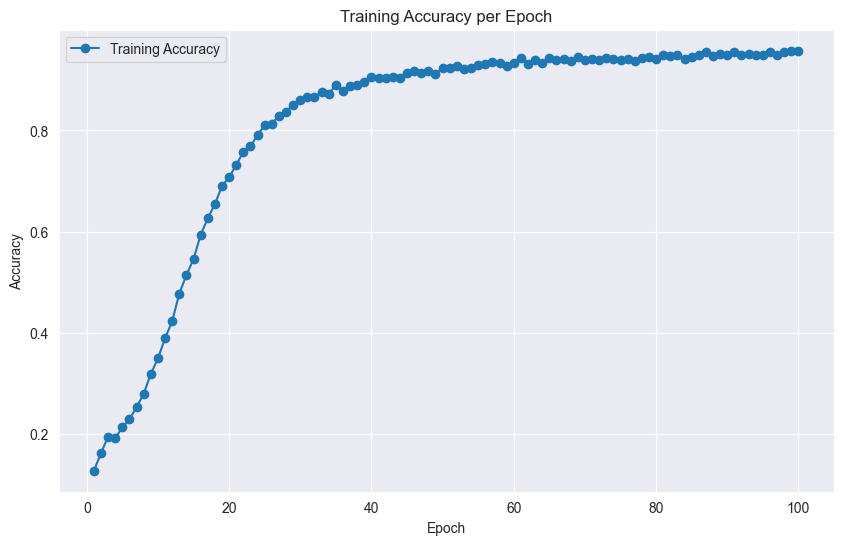

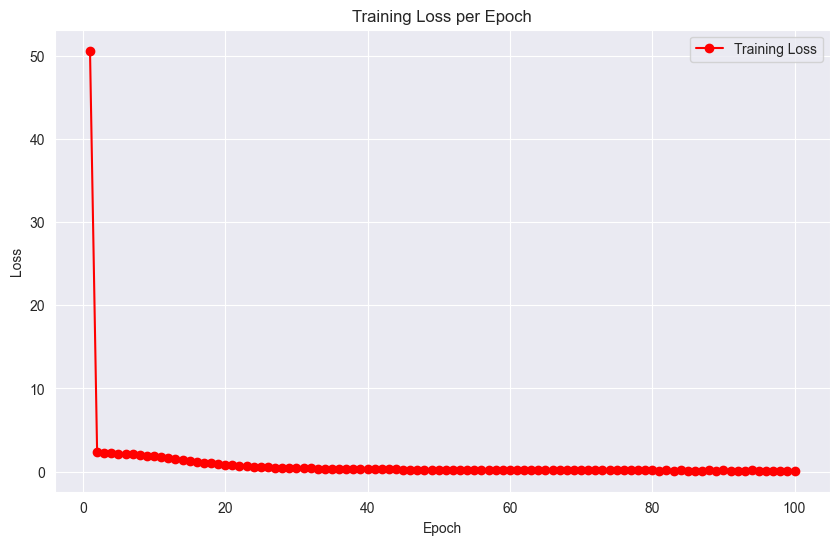

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o', label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()

## Save the Model

In [16]:
# Save the trained model
torch.save(model.state_dict(), "cnn_instrument_recognizer.pth")

## Accuracy Analysis

Accuracy: 0.3363
Precision: 0.3556
Recall: 0.3294


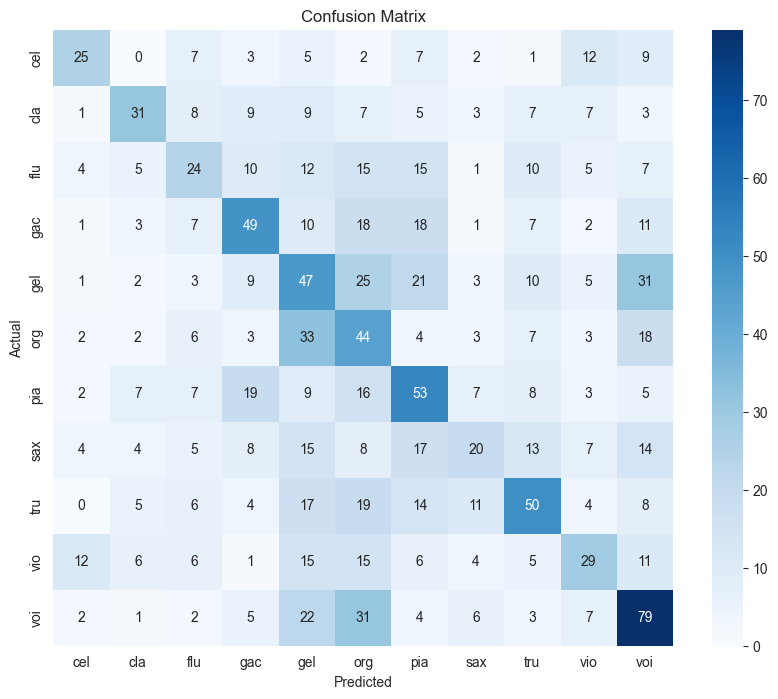

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare test data
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()